In [267]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from helpers import Trade
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import sys
import os

plt.style.use('Solarize_Light2')

# **Loading constants needed**

In [268]:
import json

with open('params.json', 'r') as file:
    data = json.load(file)

WINDOW, SIGNALS, LOWER_PRICE_DEVIATION, HIGHER_PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT, FIGSIZE=data['WINDOW'], data['SIGNALS'], data['LOWER_PRICE_DEVIATION'], data['HIGHER_PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT'], data['FIGSIZE']

# **1. Loading & Cleaning Data**

In [269]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    # gold_ticker = yf.Ticker("GC=F")
    # gold_ticker = yf.Ticker("NQ=F")
    gold_ticker = yf.Ticker("YM=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# display(df.shape)
# display(df.head(3))

- stop if the data is incomplete

In [270]:
bool_df = df.isna()
if not bool_df.loc[(bool_df['Close'] == True) | (bool_df['High'] == True) | (bool_df['Low'] == True) | (bool_df['Open'] == True)].empty:
    print("There is missing data")
    sys.exit("There is missing data")

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [271]:
df['Mean'] = df['Close'].rolling(window=WINDOW).mean()
# df['Mean'] = df['Close'].ewm(span=WINDOW, adjust=False).mean()
df['STD'] = df['Close'].rolling(window=WINDOW).std()
df['Z-Score'] = np.where(
    abs(df['High'] - df['Mean'])  > abs(df['Mean'] - df['Low']),
    (df['High'] - df['Mean']) / df['STD'],
    (df['Low'] - df['Mean']) / df['STD']
)

df['Mean'] = df['Mean'].shift(1)
df['STD'] = df['STD'].shift(1)
df['Z-Score'] = df['Z-Score'].shift(1)

df.dropna(inplace=True)

df.head(5)

,Open,High,Low,Close,Mean,STD,Z-Score
Datetime,,,,,,,
2022-10-17 11:00:00+00:00,30020.0,30031.0,29976.0,30010.0,29870.714286,128.224078,1.538601
2022-10-17 12:00:00+00:00,30006.0,30059.0,29964.0,30043.0,29858.095238,95.246472,1.815340
2022-10-17 13:00:00+00:00,30047.0,30361.0,30045.0,30174.0,29862.047619,101.221280,1.945761
2022-10-17 14:00:00+00:00,30178.0,30313.0,30072.0,30113.0,29878.523810,121.525561,3.970162
2022-10-17 15:00:00+00:00,30114.0,30260.0,30055.0,30210.0,29893.714286,130.068883,3.223567


### Overview

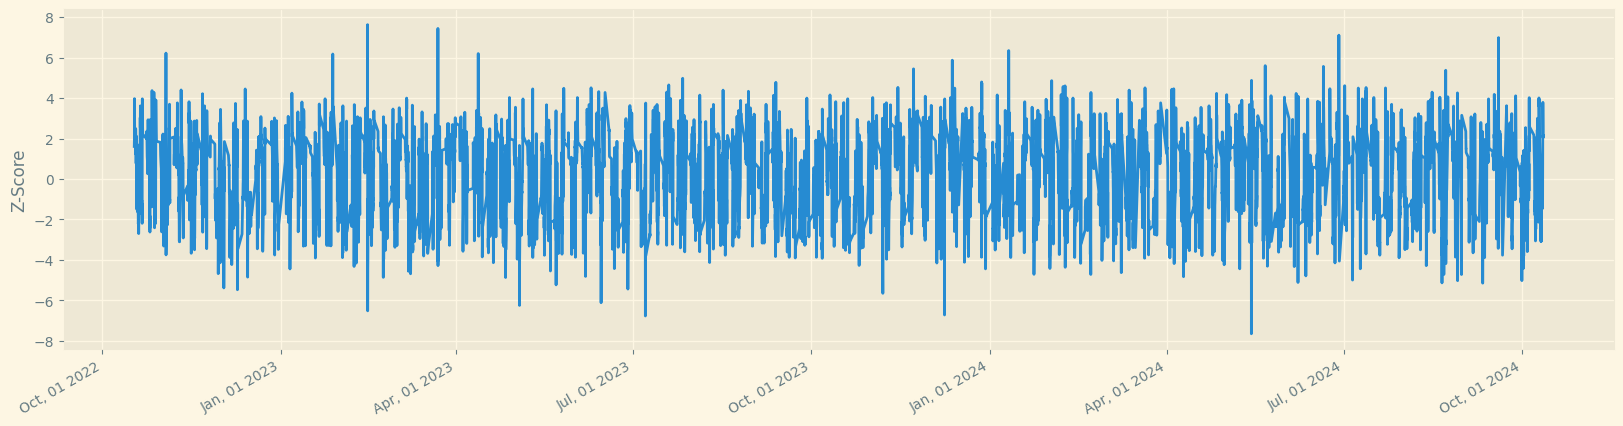

In [272]:
df['Z-Score'].plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

,Z-Score
max,7.628078
min,-7.653508


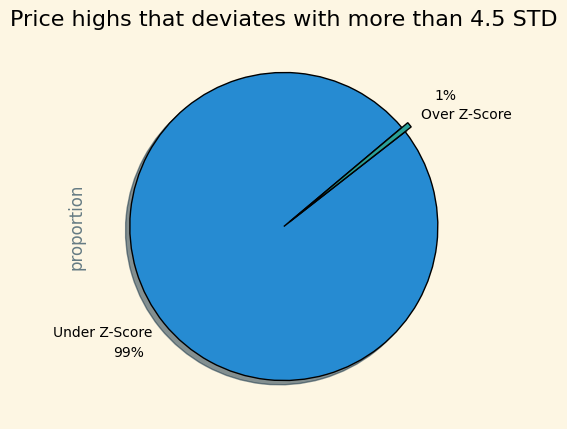

In [273]:
# stats = (abs(df['Z-Score']) > LOWER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)
stats = (abs(df['Z-Score']) > HIGHER_PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.index = ['Under Z-Score', 'Over Z-Score']

stats.plot(
    kind='pie', 
    figsize=(FIGSIZE['LEN'],FIGSIZE['LEN']),
    # title=f"Price lows that deviates with more than {LOWER_PRICE_DEVIATION['ENTRY']} STD",
    title=f"Price highs that deviates with more than {HIGHER_PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=1.3,
    labeldistance=1.1,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    startangle=40
    # colors=["#ECDFCC", "#3C3D37"]
)

df['Z-Score'].agg(['max', 'min']).to_frame()

### Generate buy/sell signals

In [274]:
price_deviate_over_xSTD_filter = df['Z-Score'] > HIGHER_PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score'] < -LOWER_PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [275]:
# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def exit_trade(idx, is_win: bool):
    df.loc[idx, 'Exit_Price'] = trade.tp if is_win else trade.sl
    pnl = trade.rrr if is_win else -1
    df.loc[idx, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trade.is_buy else 'SELL']]
    return True

def is_buy_sl(idx):
    if df.loc[idx, 'Low'] <= trade.sl: return exit_trade(idx, False)
    return False

def is_buy_tp(idx, source='High'):
    if df.loc[idx, source] > trade.tp: return exit_trade(idx, True)
    return False

def is_sell_sl(idx):
    if df.loc[idx, 'High'] >= trade.sl: return exit_trade(idx, False)
    return False

def is_sell_tp(idx, source='Low'):
    if df.loc[idx, source] < trade.tp: return exit_trade(idx, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']

    is_long = (trade_signal == SIGNALS['BUY'])

    trade.On()
    DEVIATION =  LOWER_PRICE_DEVIATION if is_long else HIGHER_PRICE_DEVIATION
    trade.entry = (_row['Mean'] - trade_signal * DEVIATION['ENTRY'] * _row['STD'])
    trade.tp = (_row['Mean'] - trade_signal * DEVIATION['TP'] * _row['STD'])
    trade.sl = (_row['Mean'] - trade_signal * DEVIATION['SL'] * _row['STD'])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if is_long:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    else:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

# Loop through candles and execute trades
for idx, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(idx): trade.Off()
            elif is_buy_tp(idx, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(idx): trade.Off()
            elif is_sell_tp(idx, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, idx)

# **4. Backtesting & Overview**

In [276]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = win_rate =(df[df['PnL'] > 0]['PnL'].count())/(df[df['PnL'] != 0]['PnL'].count())
average_RRR = df[df['PnL'] > 0]['PnL'].mean()

expectency = (average_RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        average_RRR,
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Average Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Average Risk-Reward Ratio,Expectancy,Expected return
Metrics,64.0,176.0,62.5,5.0,2.75,176.0


- Save results

In [277]:
# strategy_stats_df.to_csv("results.csv")

- **PnL**

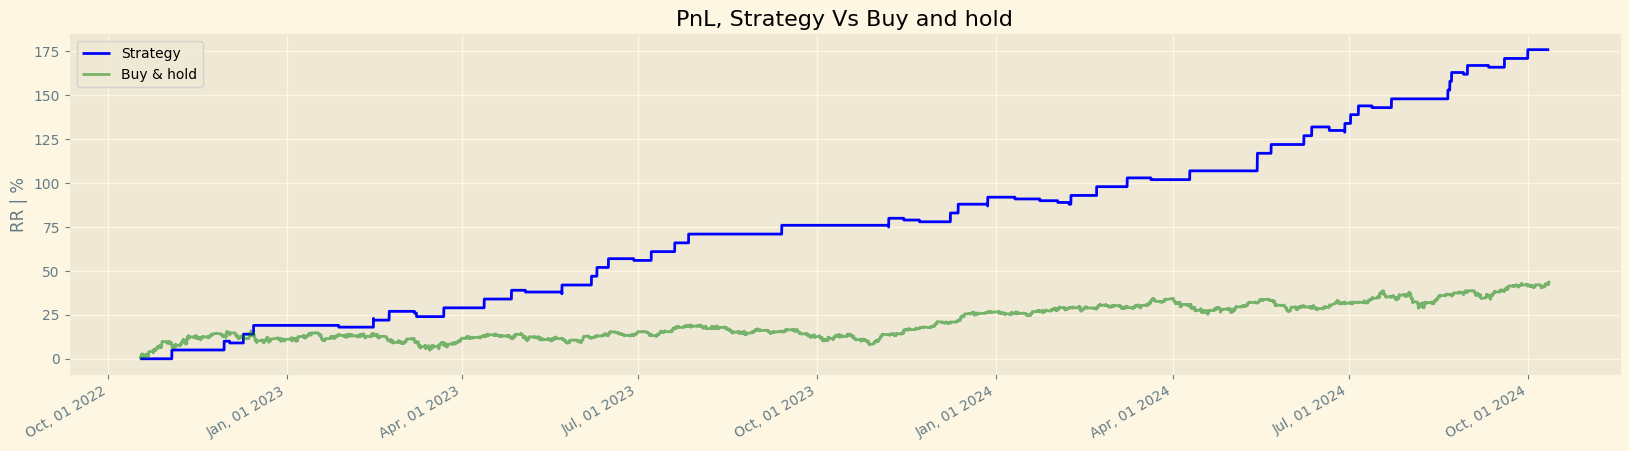

In [278]:
starting_inv_price = df['Close'].iloc[0]

# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

(100 * (df['Close'] - starting_inv_price)/starting_inv_price).plot(
        label='Buy & hold', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='green', 
        xlabel='',
        alpha=.5,
        ylabel='RR | %'
    )

plt.title('PnL, Strategy Vs Buy and hold')
plt.legend()

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

- **PnL-Drawdown** (not from Equity)

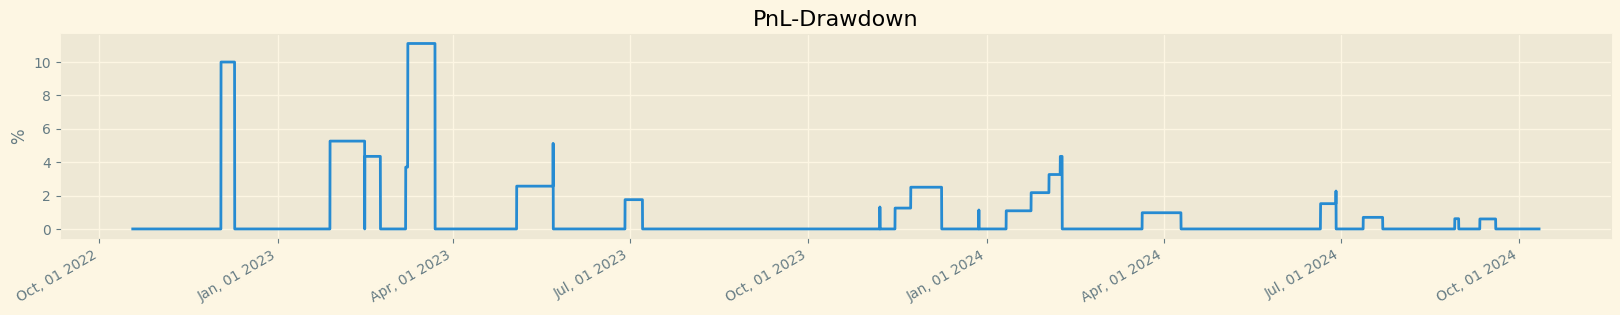

In [279]:
df['Peak'] = df['Cumulative_PnL'].cummax()

# df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / abs(df['Peak'])
df['Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

In [280]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 11.11 %


# **5. Overview on positions**

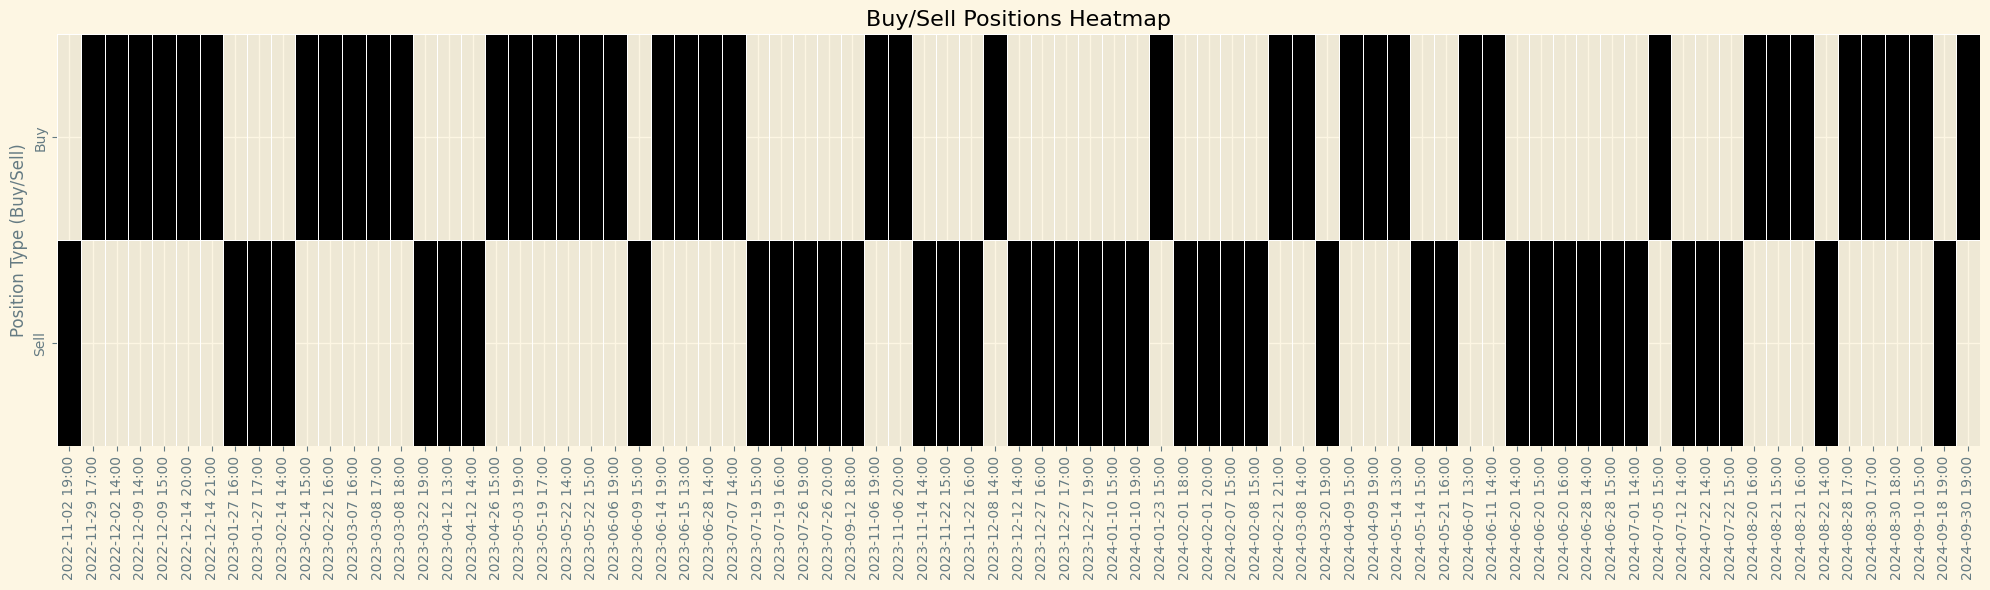

In [281]:
positions_df = pd.DataFrame(index=df.index.strftime('%Y-%m-%d %H:%M'))

positions_df['Buy'] = np.where(df['Position'] > 0, df['Position'], 0) 
positions_df['Sell'] = np.where(df['Position'] < 0, abs(df['Position']), 0) 

positions_df = positions_df.loc[(positions_df['Buy'] != 0) | (positions_df['Sell'] != 0)]

# Plot heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(positions_df.T, cmap=['#FFFFFF00', 'black'], cbar=False, linewidths=0.5)

# Customize labels and title
plt.title('Buy/Sell Positions Heatmap')
plt.xlabel('')
plt.ylabel('Position Type (Buy/Sell)')

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [282]:
# positions = df.loc[df['Position'] != 0, 'Position'].values 

# pd.Series(positions).plot(
#     figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2), 
#     yticks=[-1, 1],
#     ylabel='Buy/Sell',
#     xlabel='Trades'
# )

# plt.title('Positions nature')

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

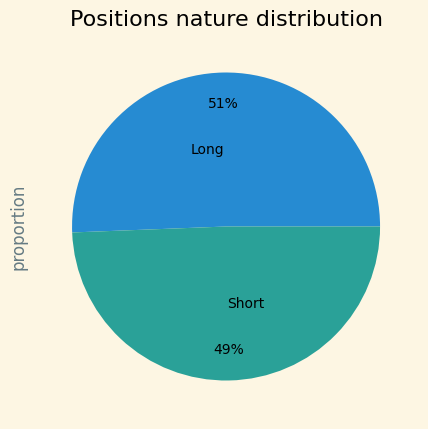

In [283]:
positions_nature_distribution_df = df.loc[df['Position'] != 0, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Long & Short from losing positions'}, ylabel='proportion'>

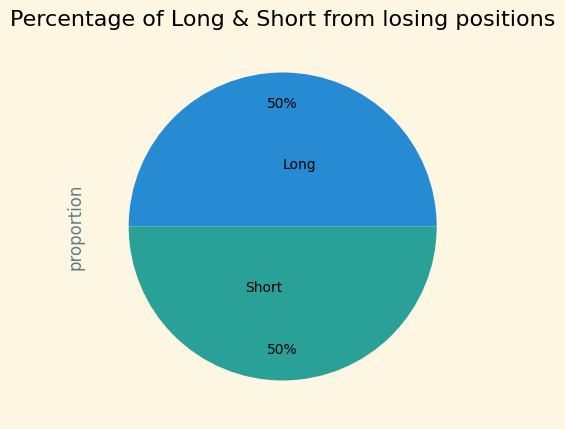

In [284]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Long & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.4
)

In [285]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)

# **6. A study on Drawdown**